# Import libraries

In [78]:
import sys
import os
import datetime as dt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta
import re

# Import data

In [79]:
ls_tracks_raw = pd.read_excel('../data/raw/Lonestar2022.xlsx', header=0)
ls_results_raw = pd.read_excel('../data/raw/Lonestar2022_results.xlsx', sheet_name=None)
print('ls_track shape: ', ls_tracks_raw.shape)
#ls_results_raw is a dictionary of data frames corresponding to excel sheets for the tasks
print('ls_results sheets: ', ls_results_raw.keys())


ls_track shape:  (216, 26)
ls_results sheets:  dict_keys(['Overall', 'Task1', 'Task2', 'Task3', 'Task4', 'Task5', 'Task6', 'Task7'])


# Clean data

In [80]:
#function to clean pilot names based on clues in their IGC file name. Very specific to this data set.
def clean_pilot_name(df, name='Pilot', file_name='IGC File name'):
    """Cleans the pilot names in Lonestar 2022 tracks data. Highly specific to these pilot names

    Args:
        df (DataFrame): data frame that contains the pilot names and file names
        name (str, optional): columns name of the pilot names. Defaults to 'Pilot'.
        file_name (str, optional): column name of the file names. Defaults to 'IGC File name'.
    """    
    df = df.copy(deep=True)
    df.loc[:, 'Pilot'] = df['IGC File name'].apply(
        lambda x: re.findall(r'[^0-9]+', x)[0].replace('Task', '').replace('-', '').replace(
            '_iljeg', 'Siljeg').replace('Davidsiljeg', 'David Siljeg').replace('Tom McCormick', 'Thomas McCormick'
                                        ).replace(
                                            'Corbin Lonestar', 'Corbin Petersen').replace(
                                                'Chris Dunlap', 'Christopher Dunlap'
                                                ).replace(
                                                    'Jaime Vargasaug', 'Jaime Vargas').strip().title())

    df.loc[:, 'Pilot'] = np.where(df['Pilot'].str.lower()=='esau', 'Esau Diaz', df['Pilot'])
    
    return(df)


## Clean tracks table

In [81]:
ls_tracks = clean_pilot_name(ls_tracks_raw, name='Pilot')
#drop row column so dedupe works later
ls_tracks.drop('Row',axis=1,inplace=True)

In [82]:
#view all the time columns
ls_tracks[[col for col in ls_tracks.columns if 'Time' in col]]

,Launch Time,Flight Time,Start Time (UTC),Landing Time
0,11:52:27,05:19:07,16:52:27,22:11:34
1,12:01:42,01:44:15,17:01:42,18:45:57
2,12:04:10,05:32:53,17:04:10,22:37:03
3,12:04:43,05:32:18,17:04:43,22:37:01
4,12:09:18,05:33:50,17:09:18,22:43:08
...,...,...,...,...
211,13:40:12,01:36:00,18:40:12,20:16:12
212,13:47:45,00:40:28,18:47:45,19:28:13
213,14:00:31,01:46:46,19:00:31,20:47:17
214,14:04:05,01:24:58,19:04:05,20:29:03


In [83]:
# Convert the datetime columns to datetime type in the tracks table
ls_tracks['Task'] = pd.to_datetime(ls_tracks['Date'], dayfirst=True)
#create a dictionary of all the tasks and thier numbers and add that to the track data
tasks_dict = dict(zip(sorted(ls_tracks['Task'].unique()),range(1, len(ls_tracks['Task'].unique())+1)))
ls_tracks['Task'] = ls_tracks['Task'].map(tasks_dict)
#calculate a flight duration in hours  of each flight 
ls_tracks['Flight Duration (hr)'] = (pd.to_timedelta(ls_tracks['Flight Time'].astype(str)).dt.seconds/3600).round(4)

date_cols = ['Launch Time', 'Landing Time']
for col in date_cols:
    ls_tracks.loc[:, col] = pd.to_datetime(ls_tracks[col].astype(str)).dt.time 


In [84]:
# checking for need to deduplicate. Tom Mccoormuick had 2 flights for task 4 which shouldn't be allowed
ls_tracks.loc[ls_tracks['Pilot']=='Thomas Mccormick', ['Task',  'Flight Time']]

,Task,Flight Time
4,1,05:33:50
36,2,06:40:25
86,3,03:02:43
108,4,02:02:50
109,4,02:02:50
126,5,00:01:04
183,6,00:12:19
210,7,00:10:04


In [85]:
#deduplicate - 1 row per pilot per task
print('Duplicated rows to remove: ')
print(ls_tracks[ls_tracks.duplicated(subset=['Pilot','Task'], keep=False)])
ls_tracks.drop_duplicates(subset=['Pilot','Task'], keep='first', inplace=True, ignore_index=False)

Duplicated rows to remove: 
     Flight Num        Date             Pilot Site Launch Time Flight Time  \
108         109  10.08.2022  Thomas Mccormick  NaN    12:53:41    02:02:50   
109         109  10.08.2022  Thomas Mccormick  NaN    12:53:41    02:02:50   

     OLC Speed  Start Height  Height Over Start  Max Height  ...  OLC km   ID  \
108        0.0            85               1938        2023  ...    42.5  NKN   
109        0.0            85               1938        2023  ...    42.5  NKN   

     Glider           GPS  Start Time (UTC)  UTC Correction  Landing Time  \
108     NKN  Flymaster,DS          17:53:41       -05:00:00      19:56:31   
109     NKN  Flymaster,DS          17:53:41       -05:00:00      19:56:31   

                                IGC File name Task Flight Duration (hr)  
108     Tom McCormick 2022-08-10_17_53_27.igc    4               2.0472  
109  Thomas McCormick 2022-08-10_17_53_27.igc    4               2.0472  

[2 rows x 27 columns]


## Clean tasks table

In [86]:
tasks_list = [task for task in ls_results_raw.keys() if 'task' in task.lower()]

In [87]:
# Combine all the tasks in one table
overall = ls_results_raw['Overall']
# capitalize names
overall.loc[:, 'Name'] = overall['Name'].str.title()
# get list of all tasks
tasks_list = [task for task in ls_results_raw.keys() if 'task' in task.lower()]

for i in range(1,len(tasks_list)+1):
    global_var_name = 'task{}'.format(i)
    task = ls_results_raw['Task{}'.format(i)]
    task = task.loc[task['Name'].isna()==False, :].copy(deep=False)
    task.loc[:, 'Name'] = task['Name'].str.title()
    task['Name'].replace('Davidsiljeg', 'David Siljeg', inplace=True)
    task['Task'] = i
    task.replace('DNF', np.nan, inplace=True)

    task['Distance'].fillna(0,inplace=True)
    task['Timed Distance']=task['Distance'].apply(lambda x: max(x-5, 0))
    #store each task in its own table
    globals()[global_var_name] = task

tasks = pd.concat([globals()['task{}'.format(i)] for i in range(1,len(tasks_list)+1)], ignore_index=True)

In [88]:
#clean distance field, make numeric and change DNFs to 0 distance flown
tasks['Distance'] = pd.to_numeric(tasks['Distance'].replace('DNF', 0))
#clean glider class
tasks['GliderClass'] = tasks['Name'].map(dict(zip(overall['Name'], overall['GliderClass'])))

#clean Time field - this is the time from the results table - the time on course
tasks['Time'] = (pd.to_timedelta(tasks['Time'].astype(str)).dt.seconds/3600).round(4)

#add task type field (manual, based on traingle, downwind, rectangle)
task_type_dict={1:'Downwind',2:'Downwind',3:'Rectangle',4:'Out-and-Back(stopped)',5:'Triangle',6:'Downwind',7:'Downwind'}
tasks['Task Type']=tasks['Task'].map(task_type_dict)

#rename some columns
tasks.rename(columns={'Name': 'Pilot', 'Total': 'Score'}, inplace=True)

#join tasks and tracks
ls = pd.merge(tasks, ls_tracks, on=['Pilot', 'Task'])

#if they got a time from the results table, that means the pilot made goal that day
ls['Made Goal'] = ls['Time'].isna()==False


In [89]:

##drop columns we're not interested in
ls.drop(columns=['Nat','Dist.','Time.1','Unnamed: 2','Adj.','Flight Num','Site',
    'OLC Speed','Landing Height','Max Gforce','OLC points','OLC km', 'ID','UTC Correction', 'GPS'], axis=1, inplace=True)


In [90]:
#add cumulative task scores to the overall dataframe
#first clean column names
overall.columns = overall.columns.str.strip()

overall['Task1_cum'] = overall['Task 1']
for i in range(2,len(tasks_list)+1):
    overall[f'Task{i}_cum'] = overall[f'Task{i-1}_cum'] + overall[f'Task {i}'] 
overall.head()

,Number,Name,Glider,GliderClass,Task 1,Task 2,Task 3,Task 4,Task 5,Task 6,Task 7,Total,Task1_cum,Task2_cum,Task3_cum,Task4_cum,Task5_cum,Task6_cum,Task7_cum
0,9,Austin Kasserman,Ozone Zeno 2,D,1000,1000,1000,163,416,791,654,5024,1000,2000,3000,3163,3579,4370,5024
1,40,Tyler Burns,Ozone Mantra 7,D,846,810,822,298,723,703,568,4770,846,1656,2478,2776,3499,4202,4770
2,23,Andrew Dahl,Ozone Zeno 2,D,911,947,397,157,739,950,89,4190,911,1858,2255,2412,3151,4101,4190
3,20,Chris Lee,Advance Omega Xalps,D,715,683,627,115,521,679,596,3936,715,1398,2025,2140,2661,3340,3936
4,35,David Prentice,777 Queen 2,C,510,835,572,152,307,736,514,3626,510,1345,1917,2069,2376,3112,3626


In [91]:
#calculate and add columns for cumulative flights time and cumulative distance through the task
cum_df = pd.DataFrame(columns=ls.columns.union(['Cumulative Flight Time']))
for pilot in ls['Pilot'].unique():
    temp_df = ls.loc[ls['Pilot']==pilot, :].copy(deep=True)
    temp_df.loc[:, 'Cumulative Flight Time'] = temp_df.loc[:, 'Flight Duration (hr)'].copy()  
    temp_df.loc[:, 'Cumulative Flight Time'] = temp_df.loc[:,'Cumulative Flight Time'].cumsum()
    cum_df = pd.concat([cum_df, temp_df], ignore_index=True)
ls=cum_df

cum_df = pd.DataFrame(columns=ls.columns.union(['Cumulative Distance']))
for pilot in ls['Pilot'].unique():
    temp_df = ls.loc[ls['Pilot']==pilot, :].copy(deep=True)
    temp_df.loc[:, 'Cumulative Distance'] = temp_df.loc[:, 'Distance'].copy()  
    temp_df.loc[:, 'Cumulative Distance'] = temp_df.loc[:,'Cumulative Distance'].cumsum()
    cum_df = pd.concat([cum_df, temp_df], ignore_index=True)
ls=cum_df

#add those cumulative scores to the ls (tracks) dataframe
for i in range(1,len(tasks_list)+1): 
    ls.loc[ls['Task']==i, 'cumulative_score'] = ls.loc[ls['Task']==i, 'Pilot'].map(dict(zip(overall['Name'], overall[f'Task{i}_cum'])))

In [17]:
#if flight duration is 0, something went wrong with the tracklog, so just assume they flew 15 km/hr
ls.loc[ls['Flight Duration (hr)']<1, 'Flight Duration (hr)' ] = ls.loc[ls['Flight Duration (hr)']==0, 'Distance']/15 

In [18]:
#calculate avg speed flown over the whole flight. 'Time' is the time taken on courseline (only for those who made goal)
ls.loc[:, 'Avg Speed (km/hr)' ] = np.where(ls['Flight Duration (hr)']>=1, ls['Distance']/ls['Flight Duration (hr)'], 0)

In [19]:
#If Start of Speed is NA, set 'Time' to 0
ls.loc[ls['SS'].isna(),'Time'] = 0 #works
#other ways to do the same line:
#ls.loc[ls['SS'].isna(),'Time']=[0]*(len(ls.loc[ls['SS'].isna()]['Time'])) #works
#ls.loc[ls['SS'].isna(),'Time'].fillna('p', inplace=True) #doesnt work
#ls.loc[:, 'Time'] = np.where(ls['SS'].isna(),0,ls['Time']) #works
#ls.loc[ls.SS.isna(), 'Time'] = 0 #works

In [20]:

#if you didn't make goal, we need to calculate your 'Time' on course
#if you didn't make goal, time on course = landing time - SS (and subtract an additional 5 for the UTC offset)
#if you did make goal, time on course = ES-SS

ls.loc[ls['Time'].isna(),'Time']=(pd.to_timedelta(ls.loc[ls['Time'].isna(), 'Landing Time'].astype(str))-pd.to_timedelta('05:00:00')-pd.to_timedelta(ls.loc[ls['Time'].isna(), 'SS'].astype(str))).dt.seconds/3600
#ls[['Pilot', 'Task', 'Time', 'Distance', 'Timed Distance', 'km/h', 'Flight Duration (hr)']].sort_values(by='Timed Distance', ascending=False)

,Pilot,Task,Time,Distance,Timed Distance,km/h,Flight Duration (hr)
1,Austin Kasserman,2,4.4825,176.72,171.72,39.0,5.1047
63,Thomas Mccormick,2,6.0169,176.72,171.72,29.0,6.6736
70,David Prentice,2,4.9822,176.72,171.72,35.1,5.8833
8,Andrew Dahl,2,4.5725,176.72,171.72,38.2,5.7856
137,Valter Castilho,2,5.6744,176.72,171.72,30.8,6.4831
...,...,...,...,...,...,...,...
173,Emily Petersen,4,1.368056,5.0,0.0,NaN,NaN
111,Robert Simpson,4,0,5.0,0.0,NaN,NaN
190,Corbin Petersen,4,0,5.0,0.0,NaN,NaN
180,Roxanne Lopez,4,0.8825,5.0,0.0,NaN,NaN


In [36]:
#calclate speed on course (ignoring the time before and after the speed section)
ls.loc[ls['Time']!=0, 'Speed on course (km/hr)'] = np.divide(ls.loc[ls['Time']!=0,'Timed Distance'], ls.loc[ls['Time']!=0,'Time'])
ls.loc[:, 'Speed on course (km/hr)'] = ls.loc[:, 'Speed on course (km/hr)'].fillna(0)

ls.loc[(ls['Speed on course (km/hr)']>100, 'Speed on course (km/hr)')] = 0

#ls[['Pilot', 'Task', 'Time', 'Distance',  'Flight Time', 'Timed Distance', 'Speed on course (km/hr)', 'km/h', 'Flight Duration (hr)']].sort_values(by='Speed on course (km/hr)', ascending=False)

,Pilot,Task,Time,Distance,Flight Time,Timed Distance,Speed on course (km/hr),km/h,Flight Duration (hr)
6,Austin Kasserman,7,1.0122,59.17,01:21:36,54.17,53.517091,56.5,1.36
128,Dustin Pachura,7,1.0194,59.17,01:28:12,54.17,53.139101,56.1,1.47
40,Max Montgomery,7,1.0767,59.17,01:24:58,54.17,50.311136,53.1,1.4161
54,Chris Lee,7,1.0825,59.17,02:41:07,54.17,50.041570,52.8,2.6853
27,Tyler Burns,7,1.1406,59.17,01:33:00,54.17,47.492548,50.1,1.55
...,...,...,...,...,...,...,...,...,...
161,Christopher Dunlap,4,0,5.0,00:31:39,0.0,0.000000,NaN,NaN
190,Corbin Petersen,4,0,5.0,00:48:42,0.0,0.000000,NaN,NaN
160,Christopher Dunlap,3,0,7.0,00:16:11,2.0,0.000000,NaN,NaN
158,Christopher Dunlap,1,0,7.0,00:08:37,2.0,0.000000,NaN,NaN


In [37]:
#xport data for visualization elsewhere
ls.to_csv('../data/interim/lonestar_cleaned.csv', index=False)

# Visualizations


<AxesSubplot:xlabel='Task', ylabel='Speed on course (km/hr)'>

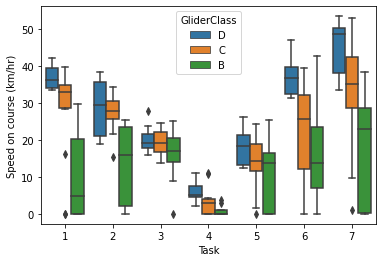

In [38]:
sns.boxplot(data=ls[ls['Max Vario']<20],x='Task',y='Speed on course (km/hr)',hue='GliderClass')

In [41]:
ls.loc[ls['Task']==4, ['Pilot', 'Task', 'Time', 'Distance',  'Flight Time', 'Timed Distance', 'Speed on course (km/hr)', 'km/h', 'Flight Duration (hr)']]

,Pilot,Task,Time,Distance,Flight Time,Timed Distance,Speed on course (km/hr),km/h,Flight Duration (hr)
3,Austin Kasserman,4,2.817778,19.3,01:39:12,14.3,5.074921,NaN,1.6533
10,Andrew Dahl,4,2.860833,17.28,02:09:44,12.28,4.292456,NaN,2.1622
17,David Siljeg,4,0,5.0,00:49:43,0.0,0.000000,NaN,NaN
24,Tyler Burns,4,2.849167,36.28,02:47:02,31.28,10.978649,NaN,2.7839
30,Josh Mcveigh,4,2.906111,11.36,01:19:17,6.36,2.188492,NaN,1.3214
37,Max Montgomery,4,4.052778,35.67,03:59:47,30.67,7.567649,NaN,3.9964
44,Chandler Papas,4,2.928056,17.21,01:34:35,12.21,4.170003,NaN,1.5764
51,Chris Lee,4,2.874167,11.01,01:37:18,6.01,2.091041,NaN,1.6217
58,Felix Figueroa,4,2.896667,18.98,01:49:08,13.98,4.826237,NaN,1.8189
65,Thomas Mccormick,4,2.941944,16.67,02:02:50,11.67,3.966764,NaN,2.0472


<AxesSubplot:xlabel='Task', ylabel='Avg Speed (km/hr)'>

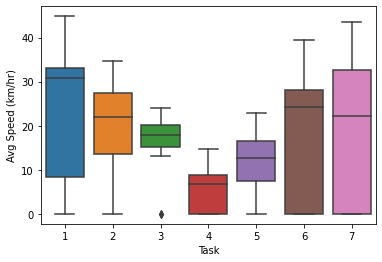

In [395]:
sns.boxplot(data=ls, x='Task', y='Avg Speed (km/hr)')
# plt.legend(bbox_to_anchor=(1, 1))


In [396]:
ls.head()

,Altitude,Cumulative Distance,Cumulative Flight Time,Date,Distance,ES,Flight Duration (hr),Flight Time,Gender,Glider,...,SS,Score,Start Height,Start Time (UTC),Task,Task Type,Time,km/h,cumulative_score,Avg Speed (km/hr)
0,NaN,175.3,4.6817,07.08.2022,175.3,16:42:56,4.6817,04:40:54,M,Zeno2 Ozone,...,12:40:36,1000.0,102,17:18:02,1,Downwind,4.0389,42.9,1000.0,37.443664
1,NaN,352.02,9.7864,08.08.2022,176.72,17:01:27,5.1047,05:06:17,NaN,Zeno2 Ozone,...,12:32:30,1000.0,88,17:06:13,2,Downwind,4.4825,39.0,2000.0,34.619077
2,NaN,483.92,15.5322,09.08.2022,131.9,17:37:55,5.7458,05:44:45,NaN,Zeno2 Ozone,...,12:17:41,1000.0,80,17:04:24,3,Rectangle,5.3372,24.3,3000.0,22.955898
3,1115.0,503.22,17.1855,10.08.2022,19.3,NaN,1.6533,01:39:12,NaN,Zeno2 Ozone,...,12:00:00,163.0,85,18:09:52,4,Out-and-Back(stopped),2.817778,NaN,3163.0,11.673622
4,NaN,560.67,19.6886,11.08.2022,57.45,NaN,2.5031,02:30:11,NaN,Zeno2 Ozone,...,14:11:49,416.0,79,18:41:01,5,Triangle,1.989722,NaN,3579.0,22.95154


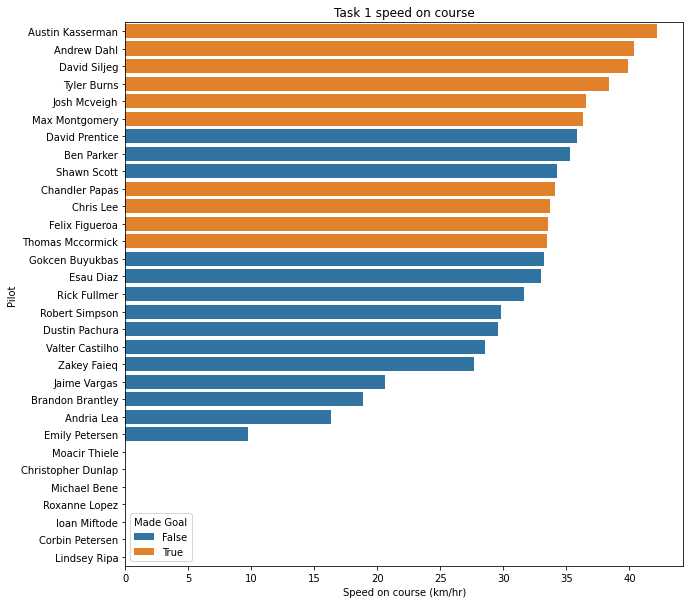

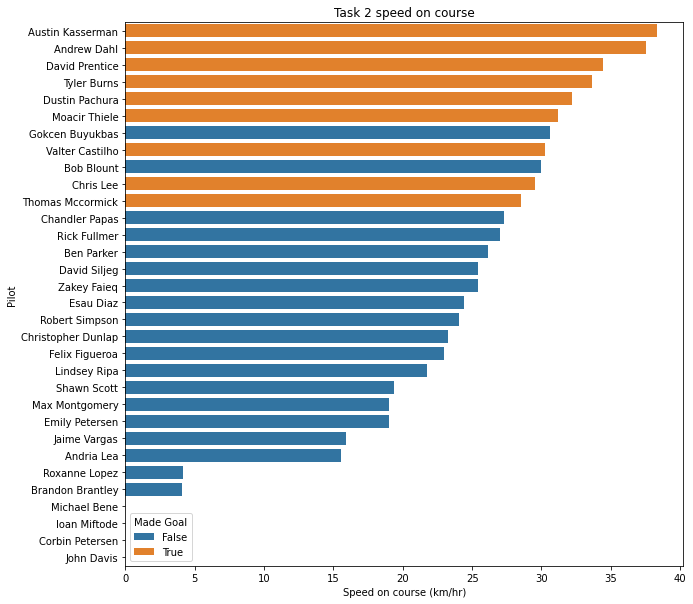

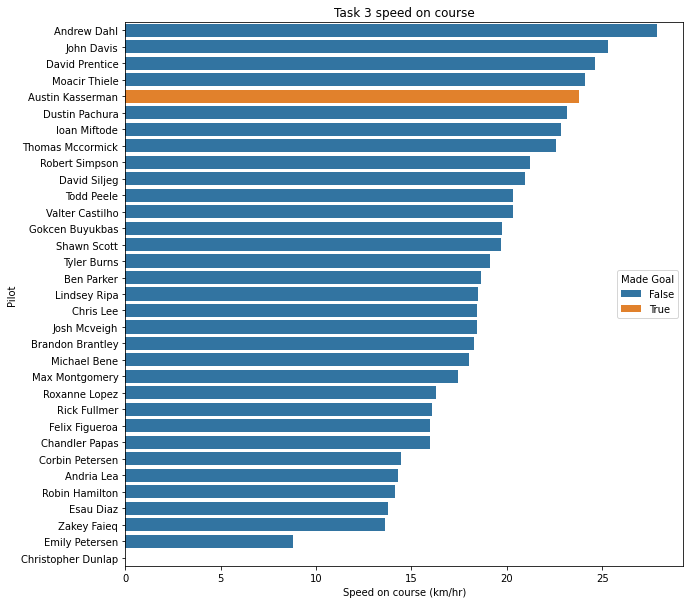

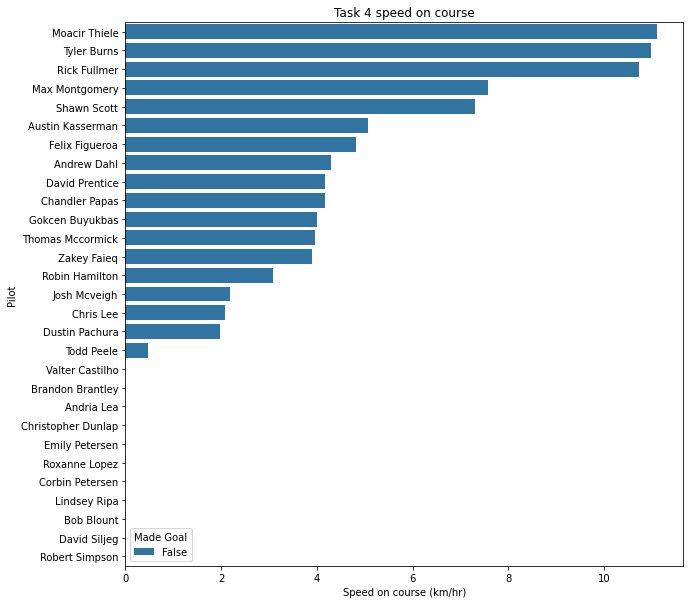

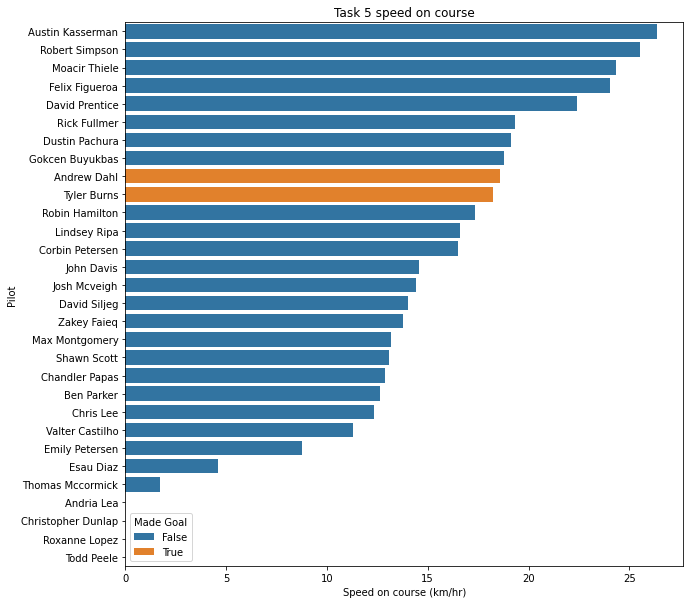

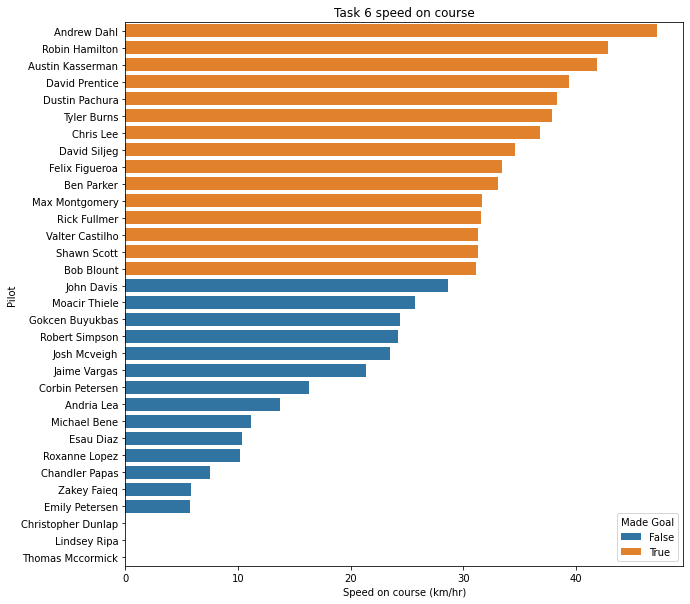

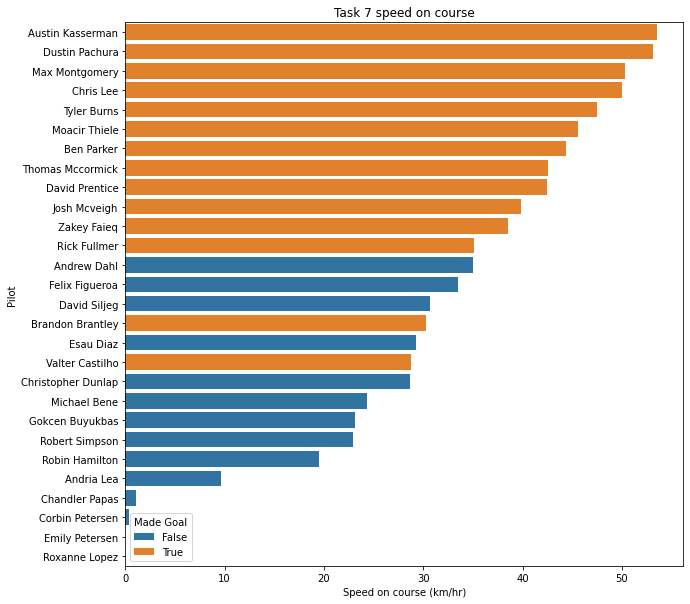

In [64]:
for i in range(1, len(tasks_list)+1):
        fig, ax = plt.subplots(figsize=(10, 10))
        sns.barplot(data=ls[ls['Task']==i].sort_values('Speed on course (km/hr)', ascending=False),
                y='Pilot',x='Speed on course (km/hr)',
                hue='Made Goal', dodge=False)
        plt.title(f'Task {i} speed on course')
        plt.show()
    # plt.xticks(rotation=90)